## [SVI Part I: An Introduction to Stochastic Variational Inference in Pyro](http://pyro.ai/examples/svi_part_i.html#SVI-Part-I:-An-Introduction-to-Stochastic-Variational-Inference-in-Pyro)

 The model has observations x and latent random variables z as well as parameters $\theta$. It has a joint probability density of the form: $$p_{\theta}({\bf x}, {\bf z}) = p_{\theta}({\bf x}|{\bf z}) p_{\theta}({\bf z})$$



$$\log p_{\theta}({\bf x}) = \log \int\! d{\bf z}\; p_{\theta}({\bf x}, {\bf z})$$

$$\theta_{\rm{max}} = \underset{\theta}{\operatorname{argmax}} \log p_{\theta}({\bf x})$$

$$p_{\theta_{\rm{max}}}({\bf z} | {\bf x}) = \frac{p_{\theta_{\rm{max}}}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta_{\rm{max}}}({\bf x} , {\bf z}) }$$

The basic idea is that we introduce a parameterized distribution $q_{\phi}({\bf z})$, where  are known as the variational parameters. This distribution is called the variational distribution in much of the literature, and in the context of Pyro it’s called the **guide** (one syllable instead of nine!). 

**Pyro enforces that model() and guide() have the same call signature, i.e. both callables should take the same arguments**.

Learning will be setup as an optimization problem where each iteration of training takes a step in $\theta-\phi$ space that moves the guide closer to the exact posterior. To do this we need to define an appropriate objective function.

The **ELBO**, which is a function of both $\theta$ and $\phi$, is defined as an expectation w.r.t. to samples from the guide:

$${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [
\log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z})
\right]$$

$$\log p_{\theta}({\bf x}) - {\rm ELBO} =
\rm{KL}\!\left( q_{\phi}({\bf z}) \lVert p_{\theta}({\bf z} | {\bf x}) \right)$$

In [1]:
import pyro
import torch

In [2]:
from pyro.infer import SVI, Trace_ELBO

In [3]:
from pyro.optim import Adam

def per_param_callable(param_name):
    if param_name == 'my_special_parameter':
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)

This simply tells Pyro to use a learning rate of 0.010 for the Pyro parameter my_special_parameter and a learning rate of 0.001 for all other parameters.

In [4]:
import pyro.distributions as dist

In [26]:
def model(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)

    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))

    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        # Each observation is assigned a unique name in Pyro.

In [27]:
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=dist.constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=dist.constraints.positive)

    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [7]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

In [43]:
auto_guide.named_parameters

<bound method Module.named_parameters of AutoNormal(
  (locs): PyroModule()
  (scales): PyroModule()
)>

The variational parameters are torch.tensors. The **requires_grad flag is automatically set to True by pyro.param**.

In [8]:
adam_params = {"lr": 0.005, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)

In [28]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [29]:
data = []

In [30]:
for _ in range(33):
    data.append(torch.tensor(1.0))
for _ in range(66):
    data.append(torch.tensor(0.0))

In [31]:
pyro.clear_param_store()

In [32]:
losses = []

In [33]:
for step in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    if step % 100 ==0:
        print('loss is {}'.format(loss))

loss is 66.02451914548874
loss is 68.37682121992111
loss is 64.17957055568695
loss is 64.21611976623535
loss is 64.22595238685608
loss is 64.593088388443
loss is 69.20848819613457
loss is 65.5210132598877
loss is 64.30919867753983
loss is 65.25618821382523
loss is 66.20701497793198
loss is 64.31662952899933
loss is 66.97081792354584
loss is 67.88015967607498
loss is 64.38547933101654
loss is 65.50882285833359
loss is 64.44707471132278
loss is 64.61033827066422
loss is 67.0732946395874
loss is 64.4147115945816


In [35]:
alpha_q = pyro.param("alpha_q").item()

In [36]:
beta_q = pyro.param('beta_q').item()

In [37]:
inferred_mean = alpha_q / (alpha_q + beta_q)

In [38]:
inferred_mean

0.3581439376485026

In [39]:
import matplotlib.pyplot as plt

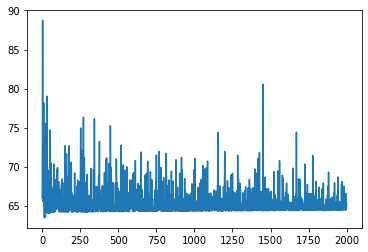

In [40]:
plt.plot(losses)